In [1]:
%%capture
!pip install xgboost==1.6.2
!pip install shap==0.41.0
!pip install pandas==1.3.5
!pip install plotly==5.10.0
!pip install scikit-learn==1.0.2

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
ap_train = pd.read_csv('application_train.csv',
                       usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
                                'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 
                                'EXT_SOURCE_2', 'EXT_SOURCE_3'])
print(f"Application train dataset shape: {ap_train.shape}")

Application train dataset shape: (248546, 26)


In [4]:
ap_train['AGE'] = -round(ap_train['DAYS_BIRTH']/365)
ap_train.drop(columns='DAYS_BIRTH', inplace=True)

# 1 INTERESTING VARIABLES

From an ethical point of view, there are some columns that might raise questions or concerns in relation to the implementation of a Machine Learning algorithm for customer classification. Listed below are the columns that may require ethical considerations:

CODE_GENDER: The inclusion of this column could raise issues of gender discrimination. If the goal is to avoid gender discrimination in the algorithm, it may be necessary to exclude this column.

OCCUPATION_TYPE: The inclusion of this column may raise issues of discrimination based on occupation. If the objective is to avoid discrimination based on occupation in the algorithm, it may be necessary to exclude this column.

DAYS_EMPLOYED: The inclusion of this column could raise issues of discrimination based on employment status or length of employment. If the objective is to avoid discrimination based on employment status in the algorithm, it may be necessary to exclude this column.


# 2 INTERESTING VARIABLES WITH RESPECT TO TARGET

For the analysis, according to the TARGET variable, some columns may be more relevant than others. Here is an evaluation of the columns according to their relevance for the analysis:

NAME_CONTRACT_TYPE: This column might not be particularly relevant for the classification of customers according to the TARGET variable. It may be considered less relevant for the analysis.

CODE_GENDER: Gender discrimination might be an important ethical and legal issue to avoid. Therefore, this column might be considered more relevant in terms of ethical considerations and might require special attention in the analysis.

FLAG_OWN_CAR: This column might have some relevance in the analysis, since car ownership might be related to the financial situation of the customer.

FLAG_OWN_REALTY: This column might also have some relevance in the analysis, since ownership of a house or flat might be related to the client's financial situation.

CNT_CHILDREN: The number of children could be a relevant variable in the analysis, as it could affect the client's financial responsibilities.

AMT_INCOME_TOTAL: This column is certainly relevant in the analysis, as the client's income is an important factor in assessing the ability to repay the loan.

AMT_CREDIT: The amount of credit requested may be a relevant factor in the analysis, as it may affect the customer's ability to repay.

AMT_ANNUITY: The amount of the loan annuity could also be relevant in the analysis, as it could indicate the financial burden of the monthly instalments for the customer.

AMT_GOODS_PRICE: This column might be relevant if the loan is related to the purchase of specific goods. However, it might be less relevant if the loan is not strictly related to the price of goods.

NAME_TYPE_SUITE: This column may not be particularly relevant for the analysis of the customer's repayment capacity and may be considered less relevant.

The remaining columns can be evaluated on the basis of the specific contexts of the analysis and the ethical considerations they might raise. It is also important to consider other factors such as data availability, correlation with the target variable and relevant local regulations.

<AxesSubplot:>

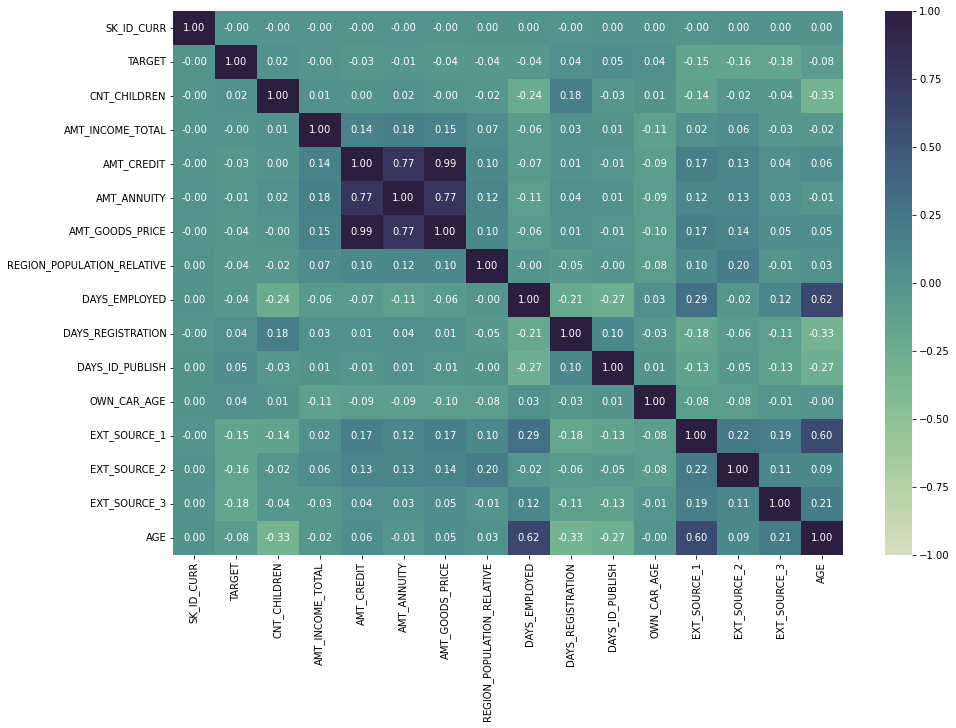

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 10))
color = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
sns.heatmap(ap_train.corr(), vmin=-1, vmax=1, annot=True, fmt='2.2f', cmap = color)

In [6]:
ap_train.corrwith(ap_train["TARGET"])

SK_ID_CURR                   -0.000528
TARGET                        1.000000
CNT_CHILDREN                  0.019583
AMT_INCOME_TOTAL             -0.001994
AMT_CREDIT                   -0.029857
AMT_ANNUITY                  -0.012380
AMT_GOODS_PRICE              -0.039151
REGION_POPULATION_RELATIVE   -0.037786
DAYS_EMPLOYED                -0.044754
DAYS_REGISTRATION             0.041722
DAYS_ID_PUBLISH               0.052948
OWN_CAR_AGE                   0.039179
EXT_SOURCE_1                 -0.154365
EXT_SOURCE_2                 -0.161405
EXT_SOURCE_3                 -0.178647
AGE                          -0.077983
dtype: float64

In [7]:
#FEATURE ENCODING
ap_train['CODE_GENDER_M'] = np.select([ap_train['CODE_GENDER'] == 'M', ap_train['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
ap_train['FLAG_OWN_CAR'] = np.where(ap_train['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train['FLAG_OWN_REALTY'] = np.where(ap_train['FLAG_OWN_REALTY'] == 'Y', 1, 0)

In [8]:
ap_objects = list(ap_train.select_dtypes(include=['object']).columns)
ap_train[ap_objects] = ap_train[ap_objects].astype('category')

In [9]:
ap_train_target = ap_train.pop('TARGET')
print(f"Target dataset shape: {ap_train_target.shape}")

Target dataset shape: (248546,)


##qua vanno aggiunti 2 3 graifici per la visualizzazione dei dati

In [10]:
#TRAIN-TEST SPLIT (80%-20%)
df_train, df_test, df_target_train, df_target_test = train_test_split(
    ap_train, ap_train_target, test_size=0.2, stratify=ap_train_target, random_state=42)

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train dataset shape: (198836, 25)
Test dataset shape: (49710, 25)


In [11]:
#XGBOOST model (parameters previously chosen with cross-validation)
df_train_dmatrix = xgb.DMatrix(df_train.drop(columns='SK_ID_CURR'), df_target_train, enable_categorical=True)

param = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}
xgb_base_model = xgb.train(param, df_train_dmatrix, num_boost_round=50)

In [12]:
#SCORE THE TEST SET
df_test_dmatrix = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results = xgb_base_model.predict(df_test_dmatrix)

What are the risk scores (from 0 to 1) of the first 5 customers in the test set? And what's the overall AUC on the test set?

In [13]:
xgb_base_test_results[:5]

array([0.2671835 , 0.18941723, 0.37044463, 0.73292816, 0.694808  ],
      dtype=float32)

In [14]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results, pos_label=1)
metrics.auc(fpr, tpr)

0.7477697343261789

The fourth customer has a higher risk score (0.732) than the others in the first 5 records.
This simple model has an AUC on the test set around 0.747, a decent baseline performance.

# 3 EVALUATING FEATURE IMPORTANCE 

<AxesSubplot:>

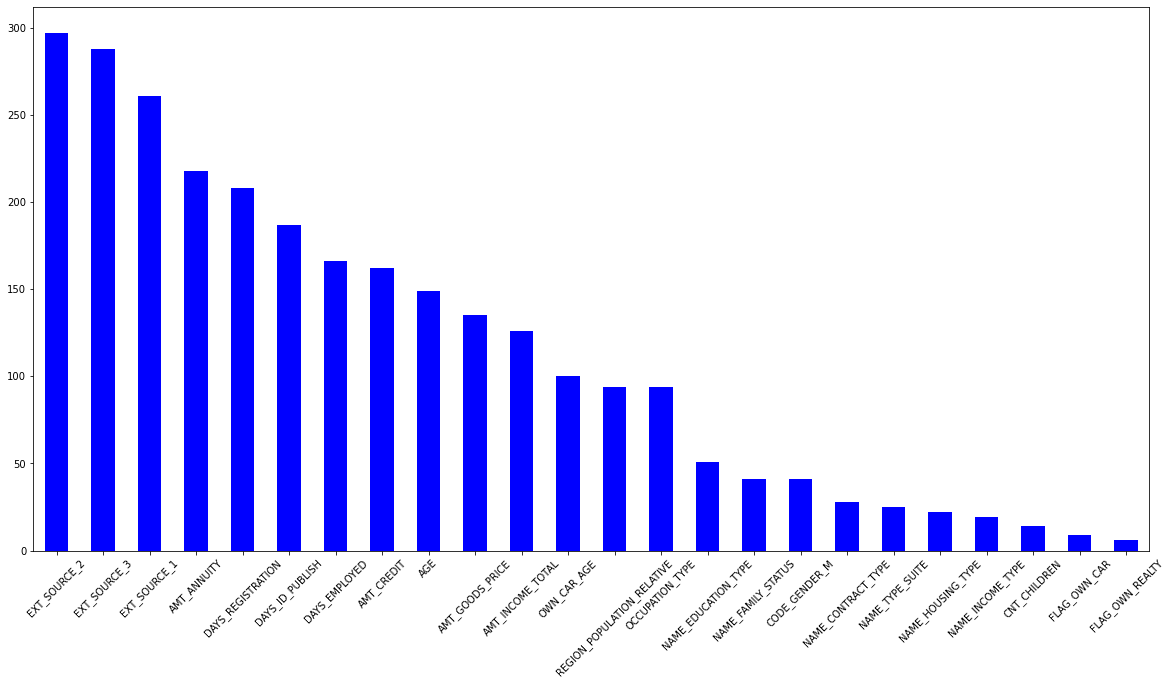

In [15]:
feature_important = xgb_base_model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40,columns="score").plot(kind='bar', figsize = (20,10), legend=False, rot=45, color="blue") ## plot top 40 features


<AxesSubplot:>

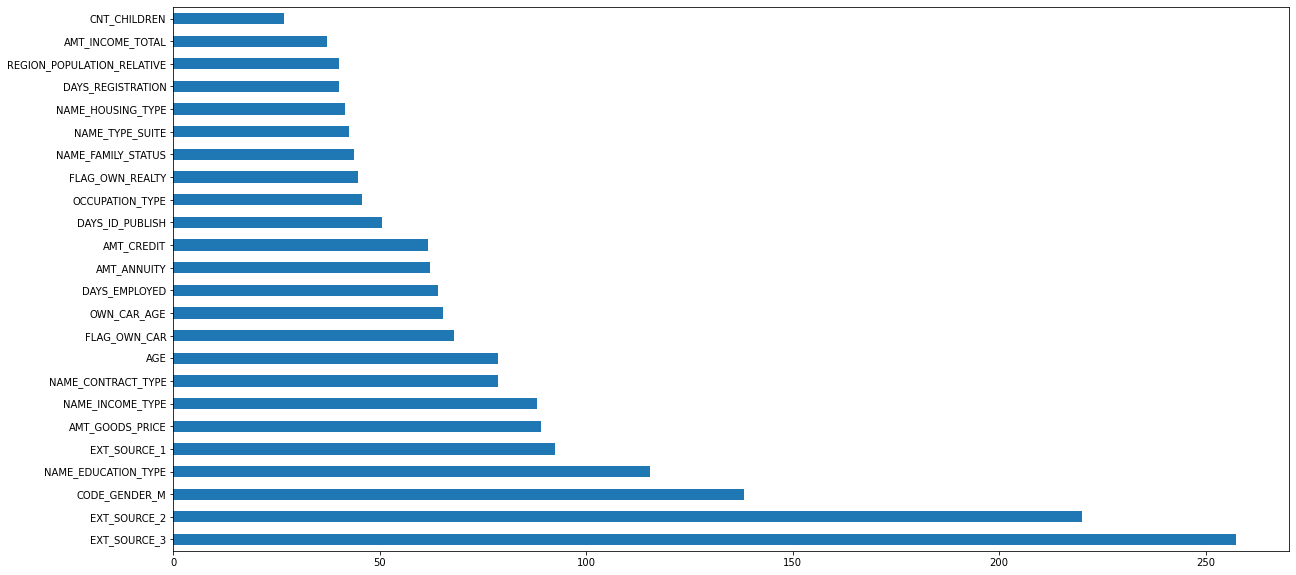

In [16]:
feature_important = xgb_base_model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10), legend=False)

# 4 COMPARING MODEL PREDICTIONS WITH RESPECT TO THE ORIGINAL TRAINING DATA 

In [17]:
df_test_dmatrix2 = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), df_target_test, enable_categorical=True)
param = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}
xgb_base_model2 = xgb.train(param, df_test_dmatrix2, num_boost_round=50)

In [18]:
xgb_base_test_results2 = xgb_base_model2.predict(df_test_dmatrix2)

In [19]:
xgb_base_test_results2[:20]

array([0.12946446, 0.05970281, 0.3018822 , 0.51293576, 0.7374824 ,
       0.2776381 , 0.2677852 , 0.18889761, 0.90731627, 0.695221  ,
       0.32659906, 0.07240656, 0.11792742, 0.5593709 , 0.13695657,
       0.17938465, 0.5575654 , 0.16314664, 0.41763946, 0.1511337 ],
      dtype=float32)

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results2, pos_label=1)
metrics.auc(fpr, tpr)

0.8791684085644879

<AxesSubplot:>

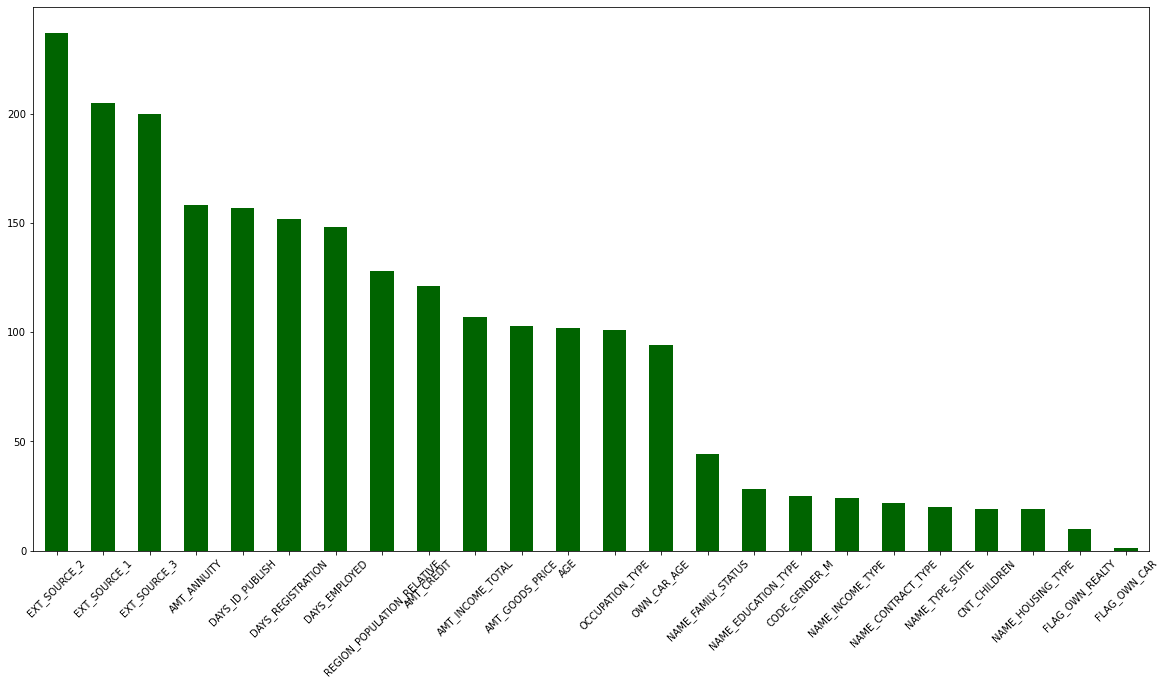

In [21]:
feature_important2 = xgb_base_model2.get_score(importance_type='weight')
keys = list(feature_important2.keys())
values = list(feature_important2.values())

data2 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data2.nlargest(40, columns="score").plot(kind='bar', figsize = (20,10), rot=45, color="darkgreen", legend=False) ## plot top 40 features

# 5 COMPARISON OF A FEW CASES, CHANGING JUST 1 OR 2 FEATURES

In [22]:
ap_train3 = pd.read_csv('application_train.csv',
                        usecols=['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                                 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                                 'OCCUPATION_TYPE',
                                 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1',
                                 'EXT_SOURCE_2', 'EXT_SOURCE_3'])


ap_train3['CODE_GENDER_M'] = np.select([ap_train3['CODE_GENDER'] == 'M', ap_train3['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
ap_train3['FLAG_OWN_CAR'] = np.where(ap_train3['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train3['FLAG_OWN_REALTY'] = np.where(ap_train3['FLAG_OWN_REALTY'] == 'Y', 1, 0)
ap_train3['NAME_CONTRACT_TYPE'] = np.where(ap_train3['NAME_CONTRACT_TYPE'] == 'Y', 1, 0)

ap_train3['AGE'] = -round(ap_train3['DAYS_BIRTH'] / 365)
ap_train3.drop(columns='DAYS_BIRTH', inplace=True)

ap_train3['NAME_EDUCATION_TYPE'] = np.random.permutation(ap_train3.NAME_EDUCATION_TYPE)
ap_train3['OCCUPATION_TYPE'] = np.random.permutation(ap_train3.OCCUPATION_TYPE)

ap_objects = list(ap_train3.select_dtypes(include=['object']).columns)
ap_train3[ap_objects] = ap_train3[ap_objects].astype('category')
ap_train_target3 = ap_train3.pop('TARGET')

df_train3, df_test3, df_target_train3, df_target_test3 = train_test_split(
    ap_train3, ap_train_target3, test_size=0.2, stratify=ap_train_target3, random_state=42)

In [23]:
df_train_dmatrix2 = xgb.DMatrix(df_train3.drop(columns='SK_ID_CURR'), df_target_train3, enable_categorical=True)

param = {'max_depth': 6,
         'eta': .2,
         'subsample': .9,
         'colsample_bytree': .9,
         'scale_pos_weight': 10,
         'objective': 'binary:logistic',
         'tree_method': 'exact'}
xgb_base_model2 = xgb.train(param, df_train_dmatrix2, num_boost_round=50)
df_test_dmatrix2 = xgb.DMatrix(df_test3.drop(columns='SK_ID_CURR'), enable_categorical=True)

In [24]:
xgb_base_test_results2 = xgb_base_model2.predict(df_test_dmatrix2)
xgb_base_test_results2[:20]

array([0.19077146, 0.16416079, 0.30139193, 0.8058549 , 0.62877375,
       0.34115097, 0.27511778, 0.11716928, 0.95061433, 0.6660429 ,
       0.24561581, 0.16017444, 0.25050458, 0.5660848 , 0.2808027 ,
       0.12604204, 0.6212643 , 0.18016627, 0.5544968 , 0.14935544],
      dtype=float32)

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test3, xgb_base_test_results2, pos_label=1)
metrics.auc(fpr, tpr)

0.7427763615049997

# 6 Wrap up: characteristics of the training dataset and how a ML model learns them

Once we had trained our model, we were able to test the results and then compare them with the first obtained results. The comparison is satisfactory and does not change the perception of the variables we had derived previously. Effectively, all variables, including those pertaining to the ethics of the individual, retain their specific weight within the prediction model.

As interesting as the graphs and data obtained by altering the variables were, we found no surprises. In fact, we imagined that by mixing the data in this way we might get a lot of confusion and information asymmetry. We interpret this as a positive sign, especially since it reflects the importance of ethical and moral data. It is no accident that by changing data for these variables, the appearance of the graphs obtained from output changes dramatically.

##questa è da parafrasare

# 7 Dropping all our concerns

In [27]:
ap_train = pd.read_csv('application_train.csv',
                       usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
                                'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 
                                'EXT_SOURCE_2', 'EXT_SOURCE_3'])
print(f"Application train dataset shape: {ap_train.shape}")

Application train dataset shape: (248546, 23)


In [28]:
ap_train_target = ap_train.pop('TARGET')
print(f"Target dataset shape: {ap_train_target.shape}")

Target dataset shape: (248546,)


In [29]:
ap_objects = list(ap_train.select_dtypes(include=['object']).columns)
ap_train[ap_objects] = ap_train[ap_objects].astype('category')

In [30]:
ap_train['FLAG_OWN_CAR'] = np.where(ap_train['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train['FLAG_OWN_REALTY'] = np.where(ap_train['FLAG_OWN_REALTY'] == 'Y', 1, 0)

In [31]:
df_train, df_test, df_target_train, df_target_test = train_test_split(
    ap_train, ap_train_target, test_size=0.2, stratify=ap_train_target, random_state=42)

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train dataset shape: (198836, 22)
Test dataset shape: (49710, 22)


In [32]:
#XGBOOST model (parameters previously chosen with cross-validation)
df_train_dmatrix = xgb.DMatrix(df_train.drop(columns='SK_ID_CURR'), df_target_train, enable_categorical=True)

param = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}
xgb_base_model = xgb.train(param, df_train_dmatrix, num_boost_round=50)

In [33]:
df_test_dmatrix = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results = xgb_base_model.predict(df_test_dmatrix)

In [34]:
xgb_base_test_results2[:20]

array([0.19077146, 0.16416079, 0.30139193, 0.8058549 , 0.62877375,
       0.34115097, 0.27511778, 0.11716928, 0.95061433, 0.6660429 ,
       0.24561581, 0.16017444, 0.25050458, 0.5660848 , 0.2808027 ,
       0.12604204, 0.6212643 , 0.18016627, 0.5544968 , 0.14935544],
      dtype=float32)

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results, pos_label=1)
metrics.auc(fpr, tpr)

0.7421093821296493

# 8 A closer look at the performance without features of ethical concern

##aggiungere commenti

# 9 Wrapping up again: what happens by just removing the features of concern

##aggiungere commenti

# 10 Hints at a possible (but questionable!) solution

##aggiungere commenti